### Load Data

In [1]:
household_id = 'idhogar'
target_column = 'Target'

from data_cleaning import get_training_data, get_test_data
train = get_training_data()
test = get_test_data()

from column_categories import building_info
building_columns = [household_id]
building_columns.extend(building_info)
building_df = train[building_columns]

from data_cleaning import target_by_household
target_household_map = target_by_household(train)
building_df = building_df.groupby(household_id).any().astype(int)
building_df = building_df.join(target_household_map)

/home/minnie/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/minnie/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Loading data from data/train.csv...
(9557, 142)

Checking for inconsistent targets...
(85,)
(9557, 142)
Cleaning inconsistent targets...
Checking inconsistent targets are gone...
(0,)
(9557, 142)

Loading data from data/test.csv...
(23856, 141)



### Build Pipeline For Different Feature Selection Techniques

In [2]:
X = building_df.drop([target_column], axis=1)
y = building_df[target_column]

In [10]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', LinearSVC(dual=False)) # Prefer dual=False when n_samples > n_features.
])

N_FEATURES_OPTIONS = [15, 18, 21]
# C_OPTIONS = [1, 10, 100]
MULTI_CLASS = ['crammer_singer']
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
#         'classify__C': C_OPTIONS,
        'classify__multi_class': MULTI_CLASS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
#         'classify__C': C_OPTIONS
        'classify__multi_class': MULTI_CLASS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipe, cv=5, n_jobs=1, param_grid=param_grid)
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'reduce_dim': [PCA(copy=True, iterated_power=7, n_components=21, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=21, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, v...2 at 0x771b2b377b70>)], 'reduce_dim__k': [15, 18, 21], 'classify__multi_class': ['crammer_singer']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scori

In [11]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(MULTI_CLASS), -1, len(N_FEATURES_OPTIONS))
# select score for best MULTI_CLASS
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

### Plot Results

Convert scores to DataFrame for plotting

In [12]:
import pandas as pd
scores = []
for label, reducer_scores in zip(reducer_labels, mean_scores):
    scores.extend(list((N_FEATURES_OPTIONS[i], s, label) for i, s in enumerate(reducer_scores)))
data = pd.DataFrame.from_records(scores)
data.columns = ['Number of features', 'Accuracy', 'Technique']
data

,Number of features,Accuracy,Technique
0,15,0.653949,PCA
1,18,0.652945,PCA
2,21,0.652945,PCA
3,15,0.655288,NMF
4,18,0.653280,NMF
5,21,0.652276,NMF
6,15,0.652945,KBest(chi2)
7,18,0.658300,KBest(chi2)
8,21,0.653949,KBest(chi2)


(0.6516733601070951, 0.6589022757697456)

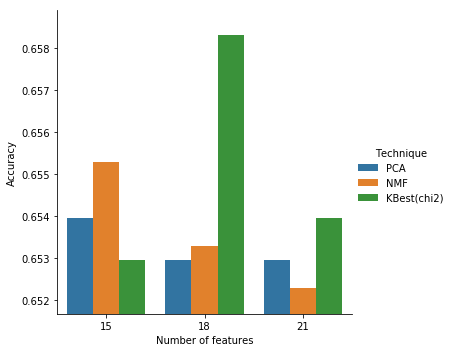

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set(style="ticks", color_codes=True)
lm = sns.catplot(x='Number of features', y='Accuracy', hue='Technique', kind='bar', data=data)

val_range = data['Accuracy'].max() - data['Accuracy'].min()
y_min = data['Accuracy'].min()-(val_range*0.1)
y_max = data['Accuracy'].max()+(val_range*0.1)

axes = lm.axes
axes[0,0].set_ylim(y_min, y_max)

### Plot Pipleline For Different UnderSampling Techniques

In [22]:
from data_cleaning import target_table_breakdown
target_table_breakdown(building_df)

,total,proportion,target description
4,1955,0.654284,non vulnerable households
2,442,0.147925,moderate poverty
3,369,0.123494,vulnerable households
1,222,0.074297,extreme poverty


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import (EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours)

# Instanciate a PCA object for the sake of easy visualisation
# Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.
pca = PCA(n_components=18)

# Create the samplers
enn = EditedNearestNeighbours()
renn = RepeatedEditedNearestNeighbours()

knn = KNeighborsClassifier(n_neighbors=5)

pipeline = make_pipeline(pca, enn, renn, knn)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)

print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

          1       0.08      0.50      0.14        50
          2       0.00      0.00      0.00       113
          3       0.00      0.00      0.00        98
          4       0.69      0.60      0.64       486

avg / total       0.45      0.43      0.43       747



/home/minnie/.ve/poverty-prediction/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
